# Simple Recommender System with Latent Factor Model _ Tao
### The content of this notebook is based on materials and knowledge from following source:
* Dataset: https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz
* Coursera: Machine Learning: Regression
* Coursera: Python Data Products for Predictive Analytics Specialization
* Book: Practical Recommender Systems, by Kim Falk
* Intelligence: Tao

# Content
* Import data + initial examination
* How to build a recommender system ?
* Ideas of latent factor model
* Learn the parameters with Gradient Descent Algorithm
* Select hyperparameters
* Recommendation Demo
* Evaluate the performance of recommender system

# Part 1: import data + initial examination

In [1]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm

import gzip
from collections import defaultdict

In [3]:
f = gzip.open('./amazon_reviews_us_Video_Games_v1_00.tsv.gz', 'rt', encoding='utf8')

In [4]:
header = f.readline()
header

'marketplace\tcustomer_id\treview_id\tproduct_id\tproduct_parent\tproduct_title\tproduct_category\tstar_rating\thelpful_votes\ttotal_votes\tvine\tverified_purchase\treview_headline\treview_body\treview_date\n'

In [5]:
header = header.strip().split('\t')
header

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [6]:
len_header = len(header)
len_header

15

## Q: Why not using pandas + delimiter='\t' directly?

In [7]:
dataset = [[] for _ in range(len_header)]

id_row = 0
for line in tqdm(f):
    row = line.strip().split('\t')
    for idx, val in enumerate(row):
        dataset[idx].append(val)
#     if id_row % 100000 == 0:
#         print(id_row)
    id_row += 1

1785997it [00:17, 100317.06it/s]


In [8]:
amazon = pd.DataFrame(dict(zip(header, dataset)))
amazon.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [9]:
amazon.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785997 entries, 0 to 1785996
Data columns (total 15 columns):
marketplace          1785997 non-null object
customer_id          1785997 non-null object
review_id            1785997 non-null object
product_id           1785997 non-null object
product_parent       1785997 non-null object
product_title        1785997 non-null object
product_category     1785997 non-null object
star_rating          1785997 non-null object
helpful_votes        1785997 non-null object
total_votes          1785997 non-null object
vine                 1785997 non-null object
verified_purchase    1785997 non-null object
review_headline      1785997 non-null object
review_body          1785997 non-null object
review_date          1785997 non-null object
dtypes: object(15)
memory usage: 204.4+ MB


In [10]:
amazon = amazon.astype({'star_rating' : int, 'helpful_votes' : int, 'total_votes' : int})

In [11]:
amazon['customer_product'] = amazon['customer_id'] +'_'+ amazon['product_id']
amazon.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,customer_product
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,12039526_B001CXYMFS
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,9636577_B00M920ND6
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,2331478_B0029CSOD2


In [12]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785997 entries, 0 to 1785996
Data columns (total 16 columns):
marketplace          object
customer_id          object
review_id            object
product_id           object
product_parent       object
product_title        object
product_category     object
star_rating          int32
helpful_votes        int32
total_votes          int32
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
customer_product     object
dtypes: int32(3), object(13)
memory usage: 197.6+ MB


In [13]:
def unique_counts(df, col_names):
    uni_counts = defaultdict(int)
    for name in col_names:
        uni = df[name].unique()
        uni_counts[name] = len(uni)
    return uni_counts

def unique_rank(df, col_names):
    for name in col_names:
        uni = df[name].value_counts()
        print(uni)

In [14]:
col_names = amazon.columns.values
uni_counts = unique_counts(amazon, col_names)
uni_counts

defaultdict(int,
            {'marketplace': 1,
             'customer_id': 1045733,
             'review_id': 1785997,
             'product_id': 65792,
             'product_parent': 63007,
             'product_title': 56237,
             'product_category': 1,
             'star_rating': 5,
             'helpful_votes': 628,
             'total_votes': 715,
             'vine': 2,
             'verified_purchase': 2,
             'review_headline': 1020973,
             'review_body': 1638977,
             'review_date': 5906,
             'customer_product': 1779460})

In [15]:
col_names = ['marketplace', 'product_category', 'star_rating', 'vine', 'verified_purchase']

unique_rank(amazon, col_names)

US    1785997
Name: marketplace, dtype: int64
Video Games    1785997
Name: product_category, dtype: int64
5    1026924
4     318246
1     192166
3     153864
2      94797
Name: star_rating, dtype: int64
N    1781706
Y       4291
Name: vine, dtype: int64
Y    1169701
N     616296
Name: verified_purchase, dtype: int64


In [16]:
uni_counts['customer_id'] * uni_counts['product_id']

68800865536

# Part 2: How to build a recommender system ?
### Considerations:
* what to recommend?  Based on what?
* based on popularity
* based on similar users' shopping list
* based on similar or linked items
* based on the user's rating or potential rating
#### Q: what's the meaning of similarity between two users?

## Q: What are the most important information?
* 1st level: user, item, rating
* 2nd level: votes, vine, verified_purchase, review
* 3rd level: others, e.g. marketplace (in this case)

# Part 3: How to model the rating - Idea behind latent factor model
considerations:

eg: user-i, item-j

mean + user + item + (user, item)

$\alpha + \beta_i + \beta_j + \vec{\gamma_i}\cdot\vec{\gamma_j}$

### Q: How to split the total dataset to train, validation, and test parts?

In [17]:
total_num = len(dataset[0])
data_ids = np.arange(total_num)
total_num, data_ids

(1785997, array([      0,       1,       2, ..., 1785994, 1785995, 1785996]))

In [18]:
np.random.shuffle(data_ids)
data_ids

array([ 953251,  656094, 1112393, ..., 1729795,  875409,   15732])

In [19]:
header.index('customer_id'), header.index('product_id')

(1, 3)

In [20]:
user_set = set()
item_set = set()
train_id = []
test_id = []

users = dataset[1]
items = dataset[3]

for k in data_ids:
    if (users[k] in user_set) and (items[k] in item_set):
        if np.random.random() < 0.1:
            train_id.append(k)
        else:
            test_id.append(k)
    else:
        train_id.append(k)    
        user_set.add(users[k])
        item_set.add(items[k])
    
len(train_id), len(test_id), len(train_id)+len(test_id), len(train_id)/(len(train_id) + len(test_id))

(1134453, 651544, 1785997, 0.6351931162258391)

In [21]:
len(user_set), len(item_set), uni_counts['customer_id'], uni_counts['product_id']

(1045733, 65792, 1045733, 65792)

In [22]:
amazon_train = amazon.loc[train_id]

test_id = np.array(test_id)
np.random.shuffle(test_id)
mid = len(test_id)//2+1
val_id = test_id[:mid]
t_id = test_id[mid:]

amazon_validation = amazon.loc[val_id]
amazon_test = amazon.loc[t_id]

amazon_train.shape, amazon_validation.shape, amazon_test.shape

((1134453, 16), (325773, 16), (325771, 16))

In [23]:
users_train = amazon_train['customer_id'].values
items_train = amazon_train['product_id'].values
labels_train = amazon_train['star_rating'].values

users_validation = amazon_validation['customer_id'].values
items_validation = amazon_validation['product_id'].values
labels_validation = amazon_validation['star_rating'].values

users_test = amazon_test['customer_id'].values
items_test = amazon_test['product_id'].values
labels_test = amazon_test['star_rating'].values

In [24]:
mean_train = np.mean(labels_train)
mean_train

3.9934990695956554

In [25]:
dataset_train = amazon_train.to_dict('records')
dataset_validation = amazon_validation.to_dict('records')
dataset_test = amazon_test.to_dict('records')

In [26]:
dataset_train[0]

{'marketplace': 'US',
 'customer_id': '18286458',
 'review_id': 'RMOS5LVFWCW2Y',
 'product_id': 'B0050SVFWE',
 'product_parent': '278855652',
 'product_title': 'DanceDanceRevolution II',
 'product_category': 'Video Games',
 'star_rating': 5,
 'helpful_votes': 0,
 'total_votes': 0,
 'vine': 'N',
 'verified_purchase': 'Y',
 'review_headline': 'It works as stablished',
 'review_body': 'It works perfect, I really love it. Just to inform, it connects to the old wiis where the connection for the previous controls was available.',
 'review_date': '2013-03-03',
 'customer_product': '18286458_B0050SVFWE'}

# Part 4: Gradient Descent Algorithm
Goal: optimize the cost function
#### important steps:
+ initialize parameters
+ calculate derivatives for each parameter
+ update parameters
+ iterate uniti max_iteration / small improvements
+ Note: avoid overfitting


In [27]:
# prediction function for one (user, item) pair

def prediction(user, item, paras):
    # unpack parameters
    alpha = paras[0]
    userBiases = paras[1]
    itemBiases = paras[2]
    userGamma = paras[3]
    itemGamma = paras[4]
    
    pred = alpha + userBiases[user] + itemBiases[item] + np.dot(userGamma[user], itemGamma[item])
    
    return pred

In [28]:
def dataset_pred(dataset, paras):
    pred = [prediction(data['customer_id'], data['product_id'], paras) for data in dataset]
    return pred

In [29]:
def cal_MSE(dataset, labels, paras):
    pred = dataset_pred(dataset, paras)
    pred = np.array(pred)
#     labels = [data['star_rating'] for data in dataset]
#     labels = np.array(labels)
    diff = pred - labels
    mse = np.dot(diff, diff) / len(pred)
    return mse

In [30]:
def cal_cost(dataset, labels, paras, l2_penalty):
    mse = cal_MSE(dataset, labels, paras)
    cost = mse
    userBiases = paras[1]
    itemBiases = paras[2]
    userGamma = paras[3]
    itemGamma = paras[4]    
    for u in userBiases:
        cost += l2_penalty * userBiases[u] ** 2
    for i in itemBiases:
        cost += l2_penalty * itemBiases[i] ** 2
    for u in userGamma:
        cost += l2_penalty * np.dot(userGamma[u], userGamma[u])
    for i in itemGamma:
        cost += l2_penalty * np.dot(itemGamma[i], itemGamma[i])
    return cost, mse

In [31]:
def derivative_ridge(dataset, paras, l2_penalty):
    
    N = len(dataset)
    
    alpha = paras[0]
    userBiases = paras[1]
    itemBiases = paras[2]
    userGamma = paras[3]
    itemGamma = paras[4] 
    
    dalpha = 0
    duserBiases = dict(zip(user_set, np.zeros(len(user_set))))
    ditemBiases = dict(zip(item_set, np.zeros(len(item_set))))
    duserGamma = dict(zip(user_set, np.zeros((len(user_set), K))))
    ditemGamma = dict(zip(item_set, np.zeros((len(item_set), K))))
    
    for d in dataset:
        u, i = d['customer_id'], d['product_id']
        pred = prediction(u, i, paras)
        diff = pred - d['star_rating']
        # from MSE
        dalpha += 2 / N * diff
        # from MSE + l2_penalty
        duserBiases[u] += 2 / N * diff
        ditemBiases[i] += 2 / N * diff
        # from MSE + l2_penalty
        for k in range(K):
            duserGamma[u][k] += 2 / N * diff * itemGamma[i][k]
            ditemGamma[i][k] += 2 / N * diff * userGamma[u][k]
            
    for u in duserBiases:
        duserBiases[u] += 2 * l2_penalty * userBiases[u]
    for i in ditemBiases:
        ditemBiases[i] += 2 * l2_penalty * itemBiases[i]
    for u in duserGamma:
        for k in range(K):
            duserGamma[u][k] += 2 * l2_penalty * userGamma[u][k]
    for i in ditemGamma:
        for k in range(K):
            ditemGamma[i][k] += 2 * l2_penalty * itemGamma[i][k]
            
    return [dalpha, duserBiases, ditemBiases, duserGamma, ditemGamma]

In [47]:
def ridge_regression_gradient_descent(dataset, paras, step_size, l2_penalty, max_iterations=30):
    
    alpha = paras[0]
    userBiases = paras[1]
    itemBiases = paras[2]
    userGamma = paras[3]
    itemGamma = paras[4]
    
    n = 1
    while n <= max_iterations:
        
        print('n=', n)
        
        # calculate derivative of parameters
        dparas = derivative_ridge(dataset, paras, l2_penalty)
        
        # update alpha
        dalpha = dparas[0]
        alpha += -1 * step_size * dalpha
        # update userBiases
        duserBiases = dparas[1]
        for u in userBiases:
            userBiases[u] += -1 * step_size * duserBiases[u]
        # update itemBiases
        ditemBiases = dparas[2]
        for i in itemBiases:
            itemBiases[i] += -1 * step_size * ditemBiases[i]
        # update userGamma
        duserGamma = dparas[3]
        for u in userGamma:
            for k in range(K):
                userGamma[u][k] += -1 * step_size * duserGamma[u][k]
        # update itemGamma
        ditemGamma = dparas[4]
        for i in itemGamma:
            for k in range(K):
                itemGamma[i][k] += -1 * step_size * ditemGamma[i][k]
                
        # assemble paras
        paras = [alpha, userBiases, itemBiases, userGamma, itemGamma]
        
        step_size /= np.sqrt(n)
        
        if n % 1 == 0:
            cost, mse = cal_cost(dataset_train, labels_train, paras, l2_penalty)
            mse_val = cal_MSE(dataset_validation, labels_validation, paras)
            test_val = cal_MSE(dataset_test, labels_test, paras)
            print('cost='+str(cost)+' __ mse='+str(mse)+' __ mse_val='+str(mse_val)+' _ mse_test='+str(test_val))
            
            rec_cost[-1].append(cost)
            rec_mse_train[-1].append(mse)
            rec_mse_val[-1].append(mse_val)
            
        n += 1
        
    return paras

## Base line model
+ use the mean rating value in the training set

In [48]:
# base line mean_train

def base_line(mean, labels):
    pred = np.zeros(len(labels)) + mean
    labels = np.array(labels)
    dif = pred - labels
    return np.dot(dif, dif) / len(dif)


In [49]:
base_train = base_line(mean_train, labels_train)
base_validation = base_line(mean_train, labels_validation)
base_test = base_line(mean_train, labels_test)
base_train, base_validation, base_test

(2.0170717126564988, 1.5382699808812206, 1.539536609777971)

# Part 5: Hyperparameter Selection
* initialize parameters
* record some important value (cost_train, mse_train, mse_cost)

In [54]:
rec_paras = []
rec_mse_train = []
rec_mse_val = []
rec_cost = []

for i, step_size in enumerate([6, 4]): # 
    rec_paras.append([])
    for l2_penalty in [0.01, 0.001, 0.0001]:
        print('step_size=', step_size)
        print('l2_penalty=', l2_penalty)
        
        rec_cost.append([])
        rec_mse_train.append([])
        rec_mse_val.append([])        

        alpha = mean_train


        # userBiases_init = np.zeros(len(user_set))
        userBiases_init = np.random.rand(len(user_set)) * 0.1 - 0.05

        # itemsBiases_init = np.zeros(len(item_set))
        itemBiases_init = np.random.rand(len(item_set)) * 0.1 - 0.05
                                         
        userBiases = dict(zip(user_set, userBiases_init))
        itemBiases = dict(zip(item_set, itemBiases_init))

        K = 2

        userGamma_init = np.random.rand(len(user_set), K) * 0.1 - 0.05
        userGamma = dict(zip(user_set, userGamma_init))

        itemGamma_init = np.random.rand(len(item_set), K) * 0.1 - 0.05
        itemGamma = dict(zip(item_set, itemGamma_init))

        init_paras = [alpha, userBiases, itemBiases, userGamma, itemGamma]        
        

        model_paras = ridge_regression_gradient_descent(dataset_train, init_paras, step_size, l2_penalty, max_iterations=10)
        rec_paras[i].append(model_paras)

step_size= 6
l2_penalty= 0.01
n= 1
cost=23.530054153770216 __ mse=2.014231227200935 __ mse_val=1.5355849505433918 _ mse_test=1.5372036486701688
n= 2
cost=18.675124932109362 __ mse=2.0128709080566387 __ mse_val=1.5555223233654865 _ mse_test=1.5570258029758801
n= 3
cost=16.09917733145316 __ mse=2.144098369302705 __ mse_val=1.5363301963762943 _ mse_test=1.5385072925940935
n= 4
cost=16.695816548720618 __ mse=4.0741334445247 __ mse_val=4.121167501744081 _ mse_test=4.1203559269374885
n= 5
cost=18.364953067836087 __ mse=6.353842244453814 __ mse_val=5.124908457026885 _ mse_test=5.129929049206463
n= 6
cost=13.795705986849018 __ mse=2.0461859012422914 __ mse_val=1.6452594160446612 _ mse_test=1.6464830142804405
n= 7
cost=13.663107802785722 __ mse=2.0184013681871895 __ mse_val=1.5851732250154682 _ mse_test=1.586543932585896
n= 8
cost=13.619986612727981 __ mse=2.014596900687166 __ mse_val=1.5746287816992621 _ mse_test=1.576030109991768
n= 9
cost=13.605138062550866 __ mse=2.0136095053741867 __ mse_v

## Graph for mse_train and mse_val of each hyper parameter pair

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

## change of mse_train during training
### Row: stepsize; Col: l2_penalty

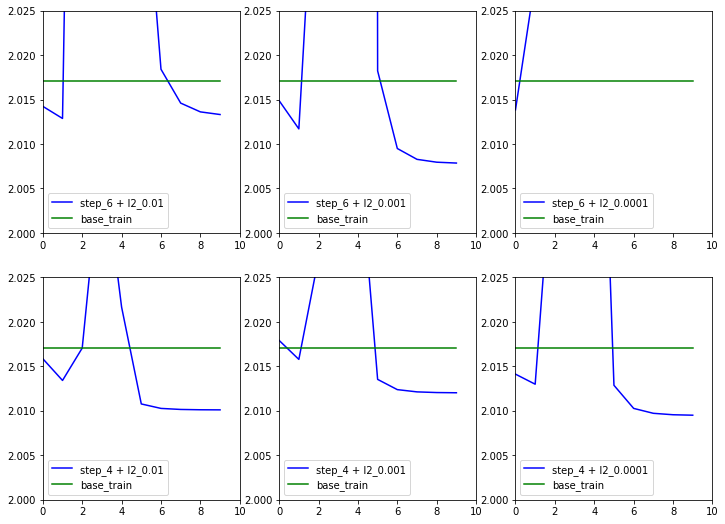

In [67]:
stepsize_list = [6, 4]
l2_list = [0.01, 0.001, 0.0001]

fig, axes = plt.subplots(2, 3, figsize=(12,9))
for i in range(6):
    row = i // 3
    col = i % 3
    axes[row, col].plot(rec_mse_train[i], 'b', label='step_'+str(stepsize_list[row])+' + l2_'+str(l2_list[col]))
    axes[row, col].plot([base_train] * 10, 'g', label='base_train')
    axes[row, col].set_xlim(0,10)
    axes[row, col].set_ylim(2.0,2.025)
    axes[row, col].legend(loc='lower left')

## change of mse_validation during training
### Row: stepsize; Col: l2_penalty

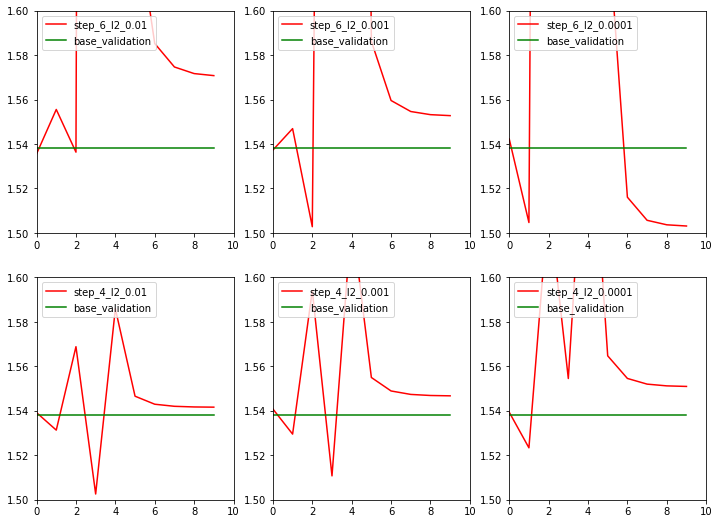

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(12,9))
for i in range(6):
    row = i // 3
    col = i % 3
    axes[row, col].plot(rec_mse_val[i], 'r', label='step_'+str(stepsize_list[row])+'_l2_'+str(l2_list[col]))
    axes[row, col].plot([base_validation] * 10, 'g', label='base_validation')
    axes[row, col].set_xlim(0,10)
    axes[row, col].set_ylim(1.5,1.6)
    axes[row, col].legend(loc='upper left')

# Re-Train the selected model

In [69]:
rec_paras = []
rec_mse_train = []
rec_mse_val = []
rec_cost = []

for i, step_size in enumerate([6]):
    rec_paras.append([])
    for l2_penalty in [0.001]:
        print('step_size=', step_size)
        print('l2_penalty=', l2_penalty)
        
        rec_cost.append([])
        rec_mse_train.append([])
        rec_mse_val.append([])        

        alpha = mean_train


        # userBiases_init = np.zeros(len(user_set))
        userBiases_init = np.random.rand(len(user_set)) * 0.1 - 0.05

        # itemsBiases_init = np.zeros(len(item_set))
        itemBiases_init = np.random.rand(len(item_set)) * 0.1 - 0.05
                                         
        userBiases = dict(zip(user_set, userBiases_init))
        itemBiases = dict(zip(item_set, itemBiases_init))

        K = 2

        userGamma_init = np.random.rand(len(user_set), K) * 0.1 - 0.05
        userGamma = dict(zip(user_set, userGamma_init))

        itemGamma_init = np.random.rand(len(item_set), K) * 0.1 - 0.05
        itemGamma = dict(zip(item_set, itemGamma_init))

        init_paras = [alpha, userBiases, itemBiases, userGamma, itemGamma]        
        

        model_paras = ridge_regression_gradient_descent(dataset_train, init_paras, step_size, l2_penalty, max_iterations=20)
        rec_paras[i].append(model_paras)

step_size= 6
l2_penalty= 0.001
n= 1
cost=4.7275334812673275 __ mse=2.014986850578084 __ mse_val=1.5391634559441973 _ mse_test=1.5404408791846713
n= 2
cost=4.659661899357229 __ mse=2.0117967088698103 __ mse_val=1.5269075621472097 _ mse_test=1.5282531453185264
n= 3
cost=4.65499737798327 __ mse=2.0518296132358405 __ mse_val=1.654096399492571 _ mse_test=1.6550461848267408
n= 4
cost=5.24575413624254 __ mse=2.6679927181409915 __ mse_val=1.9001362525808883 _ mse_test=1.9028605416181636
n= 5
cost=5.9616827980023155 __ mse=3.39651242749035 __ mse_val=3.351738146438922 _ mse_test=3.35102047932529
n= 6
cost=4.578176500825876 __ mse=2.0186139891457286 __ mse_val=1.505454234162802 _ mse_test=1.5069709495229324
n= 7
cost=4.56690615255914 __ mse=2.0096283124572323 __ mse_val=1.5148553386984032 _ mse_test=1.5162851744181363
n= 8
cost=4.564788817492594 __ mse=2.008373838681626 __ mse_val=1.5174521310308995 _ mse_test=1.5188639250391676
n= 9
cost=4.564154709708704 __ mse=2.0080447103802586 __ mse_val=1.

# mse_train, mse_validation of selected model vs base line

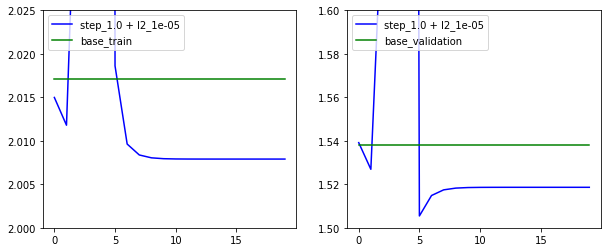

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(rec_mse_train[0], 'b', label='step_'+str(1.)+' + l2_'+str(1e-5))
axes[0].plot([base_train] * 20, 'g', label='base_train')
axes[0].set_ylim(2.0,2.025)
axes[0].legend(loc='upper left')

axes[1].plot(rec_mse_val[0], 'b', label='step_'+str(1.)+' + l2_'+str(1e-5))
axes[1].plot([base_validation] * 20, 'g', label='base_validation')
axes[1].set_ylim(1.5,1.6)
axes[1].legend(loc='upper left')

In [72]:
selected_para = model_paras

# Part 6: Recommendation Demo


## Popularity Model

In [73]:
popular_items = amazon_train['product_id'].value_counts()

In [74]:
popular_item_ids = popular_items.index.values
popular_item_ids # most popular product_ids

array(['B00BGA9WK2', 'B007FTE2VW', 'B005CPGHAA', ..., '9861748563',
       'B00HUHV0VO', 'B00006LEMH'], dtype=object)

In [75]:
names_train = amazon_train['product_title'].values
itemNames = dict(zip(items_train, names_train))

In [76]:
# test
itemNames['B00BGA9WK2']

'PlayStation 4 500GB Console [Old Model]'

In [77]:
def popularity_rec(user, n=10):
    recommendation = [itemNames[x] for x in popular_item_ids[:n]]
    return recommendation

In [78]:
popularity_rec('A')

['PlayStation 4 500GB Console [Old Model]',
 'SimCity - Limited Edition',
 'E-3lue Cobra EMS109BK High Precision Gaming Mouse with Side Control 1600dpi',
 'Diablo III - PC/Mac',
 'Spore',
 'Grand Theft Auto V',
 'Microsoft Xbox360 Wireless Controller Microsoft',
 'Grand Theft Auto V',
 'Xbox LIVE 12 Month Gold Membership Card',
 'PlayStation 3 Dualshock 3 Wireless Controller (Black)']

## Latent Factor Model

In [88]:
users_train[:15]

array(['18286458', '26007273', '16089550', '50280260', '38711633',
       '44288097', '15482488', '48770717', '12423378', '30385032',
       '42633339', '485665', '46254198', '42218209', '51370721'],
      dtype=object)

In [90]:
def model_rec(paras, user, n=10):
    ranking = []
    for d in dataset_train:
        item = d['product_id']
        score = prediction(user, item, paras)
        ranking.append((score, item))
        
    ranking.sort(reverse=True)
    recommendation_set = set()
    
    for score_item in ranking:
        recommendation_set.add(score_item)
        if len(recommendation_set) == 10: break
            
    recommendation_list = list(recommendation_set)
    recommendation_list.sort(reverse=True)
    recommendation = [itemNames[x[1]] for x in recommendation_list]
    
    return recommendation

In [93]:
test_user =   '48770717'
model_rec(selected_para, test_user)

['Grand Theft Auto V',
 'Grand Theft Auto V',
 'Xbox Live Subscription',
 'Just Dance 4',
 "Assassin's Creed 4",
 'The Last of Us',
 'Official Nintendo White Classic Gamecube Controller',
 'Roller Coaster Tycoon',
 'PlayStation 4 Console - Destiny Bundle [Discontinued]',
 'Fallout 3: Game of The Year Edition']

# Part 7: Evaluate Recommendation Performance
+ picture: a system shows you 10 recommendated products
+ valid recommendation: if the purchased one is within this list
+ metric: purchased rate. valid recommendation / total recommendation

## Popularity Model

In [94]:
popularity_performance = []
for u, i in zip(users_test, items_test):
    rec = popularity_rec(u)
    if itemNames[i] in rec:
        popularity_performance.append(1)
    else:
        popularity_performance.append(0)

In [96]:
sum(popularity_performance), len(popularity_performance)

(5922, 325771)

In [97]:
popularity_purchased_rate = sum(popularity_performance) / len(popularity_performance)
popularity_purchased_rate

0.01817841367095291

+ This means if we recommend 10 most popular items, about two people will purchase some items from the list.

## Latent Factor Model

In [98]:
users_test_set = set(users_test)
items_test_set = set(items_test)

In [99]:
print(len(users_test_set), len(items_test_set))

166814 32156


In [100]:
usersNum_test = dict(zip(users_test_set, range(len(users_test_set))))
numUsers_test = dict(zip(range(len(users_test_set)), users_test_set))
itemsNum_test = dict(zip(items_test_set, range(len(items_test_set))))
numItems_test = dict(zip(range(len(items_test_set)), items_test_set))

In [101]:
users_train_set = user_set
items_train_set = item_set

In [102]:
print(len(users_train_set), len(items_train_set))

1045733 65792


In [103]:
itemsNum_train = dict(zip(items_train_set, range(len(items_train_set))))
numItems_train = dict(zip(range(len(items_train_set)), items_train_set))

In [104]:
users_items_scoreMatrix = np.full((len(users_test_set), len(items_train_set)), -1.)
users_items_scoreMatrix.shape

(166814, 65792)

In [109]:
k = 0 # variable for monitoring
for one_user in usersNum_test:
    k += 1

    # use the following comment while testing code
#     if k == 10: break

    if k % 5000 == 0: print('k='+str(k))
    u_num = usersNum_test[one_user]
    for i_num in range(len(items_train_set)):
        one_item = numItems_train[i_num]
#         score = selected_para[0] + selected_para[1][one_user] + selected_para[2][one_item] \
#                 + np.dot(selected_para[3][one_user], selected_para[4][one_item])
        score = prediction(one_user, one_item, selected_para)
        users_items_scoreMatrix[u_num, i_num] = score

k=5000
k=10000
k=15000
k=20000
k=25000
k=30000
k=35000
k=40000
k=45000
k=50000
k=55000
k=60000
k=65000
k=70000
k=75000
k=80000
k=85000
k=90000
k=95000
k=100000
k=105000
k=110000
k=115000
k=120000
k=125000
k=130000
k=135000
k=140000
k=145000
k=150000
k=155000
k=160000
k=165000


In [107]:
users_items_scoreMatrix[:3,:5]

array([[4.02625614, 4.07419134, 4.01016376, 4.07499865, 4.05362715],
       [4.04294932, 4.09290196, 4.02540869, 4.0932484 , 4.0699991 ],
       [4.05898585, 4.10616587, 4.04136891, 4.10827839, 4.08974897]])

In [110]:
from tqdm.auto import tqdm

In [111]:
model_performance = []
k = 0
for u, i in tqdm(zip(users_test, items_test)):
#     k += 1
#     if k % 5000 == 0: print('k='+str(k)+'__sum='+str(sum(model_performance)))
#     if k == 1000: break
    u_num = usersNum_test[u]
    top10_numItems = np.argsort(users_items_scoreMatrix_test[u_num])[-10:]
    recommendation = [numItems_test[x] for x in top10_numItems]
    if i in recommendation:
        model_performance.append(1)
    else:
        model_performance.append(0)

In [114]:
sum(model_performance), len(model_performance)

(10338, 325771)

In [115]:
model_purchased_rate = sum(model_performance) / len(model_performance)
model_purchased_rate

0.03173394808009307

# Compare Purchased Rate
+ Popularity Model: 0.018
+ Latent Factor Model: 0.032
### conclusion: 
* By applying latent factor model, the purchased rate is increased by ~0.014.
* Latent factor model is able to offer more personalized recommendations than the popularity model.

# Part 8: Reflection & Thoughts for Improvements
+ parallelize some for loops to speed up the calculation
+ combine with other information about users and items
+ reviews can help to identify the reason for high rating and low rating
+ recommendation should also consider time factor